<a href="https://colab.research.google.com/github/Devikasree099/FMML-register/blob/main/Copy_of_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data
## Lab 3: Manifold Learning Methods


```
Coordinator: Aswin Jose
```

---



Today, we will be focussing on non-linear dimensionality reduction methods or **Manifold learning** methods.

So a manifold is any space that is locally Euclidean. For example, the Earth is round but it looks flat to us. The Earth is a manifold: locally it is flat, but globally we know it is a sphere. Then, manifold learning performs dimensionality reduction by representing data as low-dimensional manifolds embedded in a higher-dimensional space.

We often suspect that high-dim may actually lie on or near a low-dim manifold (often much lower!) and it would be useful if we could reparametrize the data in terms of this manifold, yielding a low-dim embedding BUT - we typically don’t know the form of this manifold.

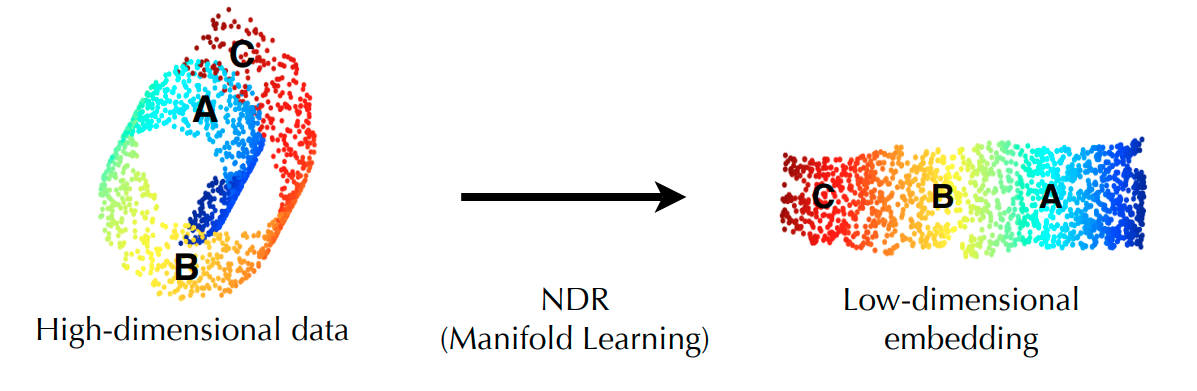

## ISOMAP

---

Isomap stands for **ISOmetric feature MAPping**. Isomap is a non-linear dimensionality reduction method based on the spectral theory which tries to preserve the geodesic distances in the lower dimension.

#### But what are Geodesic Distances?



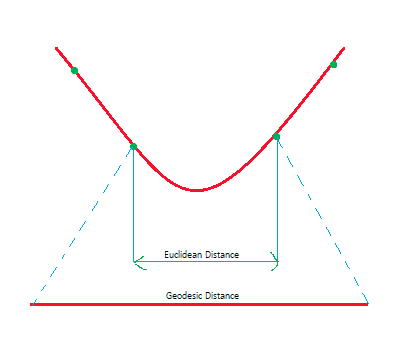

The next question should be:

*How can we compute geodesics without knowing the manifold?* .......
ANSWER: So we build an adjacency graph and approximate geodesic distances by shortest-paths through the graph.


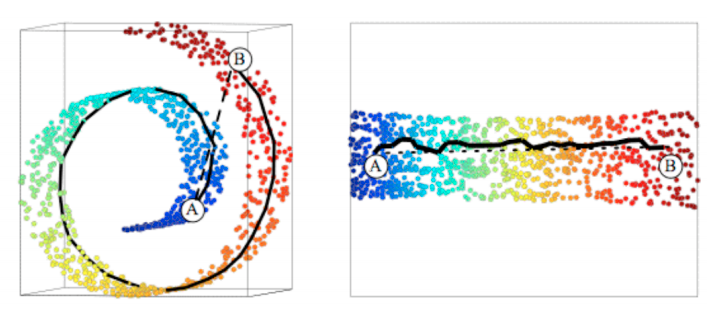

#### 3 steps for ISOMAP:

1. Build the adjacency graph over the points using a Neighbourhood selection method (let's say k nearest neighbours)
2. Compute approximate geodesics: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.
3. Take the top d eigenvectors of the Gram matrix.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

First let us simulate a dataset with the points lying on a manifold which we would want our Isomap to be able to capture.

We will be using the make_s_curve() function in the sklearn.datasets module to make the manifold using 1000 data points

In [ ]:
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)

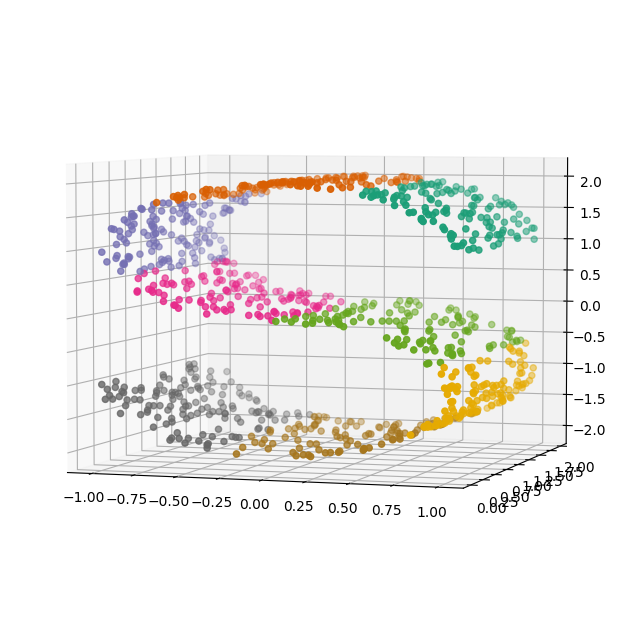

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2)
ax.view_init(4, -72)

Note that all the points appear to be a lying on a curved 2d plane in this 3d dataset. Now we will be coding the Isomap algorithm to perform this manifold learning.


---

### Step 1a: First lets compute the distance matrix (pairwise Euclidean distances) from the data


In [ ]:
def dist(a, b):
  '''Computes Euclidean distance between 2 points'''
  return np.sqrt(sum((a - b) ** 2))

distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

# For N points in the dataset, this matrix should be of the dimension NxN.
# Our dataset had 1000 points, so we expect the dimensions of this matrix to be 1000x1000
print(distances.shape)

(1000, 1000)


### Step 1b: Let us keep only k nearest neighbors for each point in the distance matrix.

In [ ]:
# Lets keep only the 10 nearest neighbors, others set to 0 (= unreachable)

n_neighbors = 10
neighbors = np.zeros(distances.shape)

sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
for k,i in enumerate(sort_distances):
    neighbors[k,i] = distances[k,i]

In [ ]:
neighbors.shape

(1000, 1000)



---

### Step 2: Weight graph edges by inter-point distances and then apply Dijkstra’s all-pairs shortest-paths algorithm.

We will be using the graph_shortest_path() function in the sklearn.utils.graph module.

The function takes an array of positive distances as the parameter. It then performs a shortest-path graph search on the graph and returns a matrix G (shape = N,N), where, G(i,j) gives the shortest distance from point i to point j along the graph.


In [ ]:
from scipy.sparse.csgraph import shortest_path

graph = shortest_path(neighbors, directed=False)



---
### Step 3: Take the top d eigenvectors of the Gram matrix.


So let us first compute the gram matrix. If we have a matrix **graph**, then its Gram matrix is **graph**.T * **graph**





In [ ]:
gram = (graph ** 2)

We will now be computing the eigenvectors for this matrix, so lets first center the data points.

In [ ]:
n_samples = gram.shape[0]

# Mean for each row/column
meanrows = np.sum(gram, axis=0) / n_samples
meancols = (np.sum(gram, axis=1)/n_samples)[:, np.newaxis]

# NUMPY TRICKS: np.newaxis is used to increase the dimension of the existing array by one more dimension. So a (1000,) matrix becomes a (1000,1) matrix.

# Mean across all rows (entire matrix)
meanall = meanrows.sum() / n_samples

gram -= meanrows
gram -= meancols
gram += meanall

Computing eigenvectors

In [ ]:
# Using the np.linalg.eig() to compute eigenvectors and eigenvalues for the matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)

# We will be sorting the eigenvalues and to preserve the corresponding eigenvectors, let us make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]

# We want to reduce the dimensionality to **n_components** dimensions, therefore we will be first taking the top **n_components** eigenvectors (sorted in descending by eigenvalues)
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

# Transforming the matrix (dimensionality reduction)
n_components = 2

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T



---

## Plotting the resultant reduced_matrix


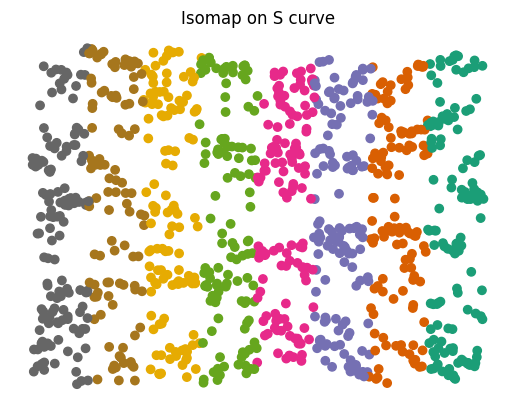

In [ ]:
ax = fig.add_subplot(111)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

##### As you can see the Isomap was able to capture the underlying 2d manifold in the S curve dataset.

Now of course there is an easier way to do this, using a predefined library Isomap by sklearn in the manifold module. It just requires you to enter the number of neighbours to be considered and the number of components the graph is to be reduced to.


In [ ]:
from sklearn.manifold import Isomap

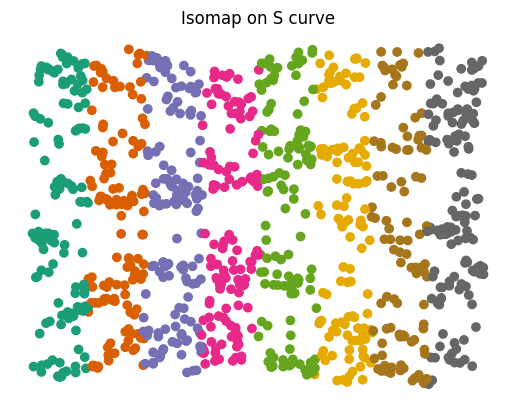

In [ ]:
Y = Isomap(n_neighbors=10, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()



---

### Now let us see if Isomap can learn the manifold representation in some more complex datasets

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200)
faces.data.shape

(766, 2914)

We loaded 766 images, each having 2914 pixels. Let us visualize our dataset before reducing the dimension

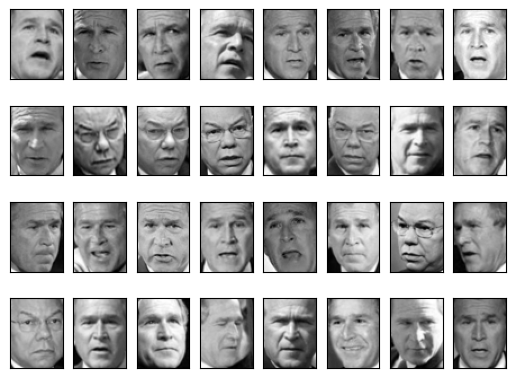

In [ ]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Our data is 2914 dimensional and our goal is to learn a low dimensional manifold from it. We first apply PCA (which we learn in Lab 2) and see if PCA is able to reduce it to lower dimensions while preserving much of the variance.

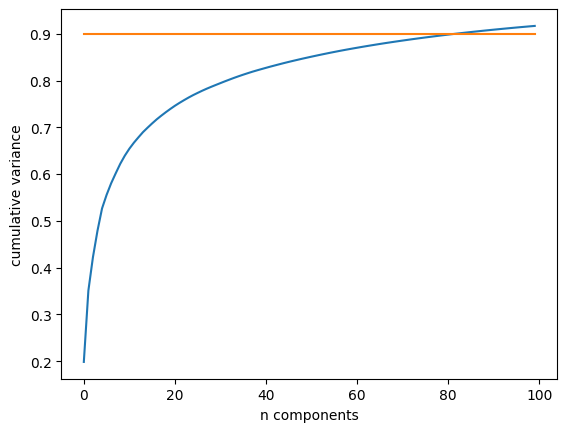

In [ ]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 0.9*np.ones(100))

So we can clearly observe that PCA requires more than 70 dimensions to be able to explain 90% of the variance, implying that PCA is failing to learn the underlying manifold effectively.

Let us now try to apply Isomap to this dataset and see if it is able to learn the representation effectively.

In [ ]:
model = Isomap(n_components=2, n_neighbors = 5)
proj = model.fit_transform(faces.data)
proj.shape

(766, 2)

We have reduced the dataset from 2914 dimensions to just 2 dimensions. Let us now visualize the result to be able to better understand the latent representation learnt by Isomap

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):

    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

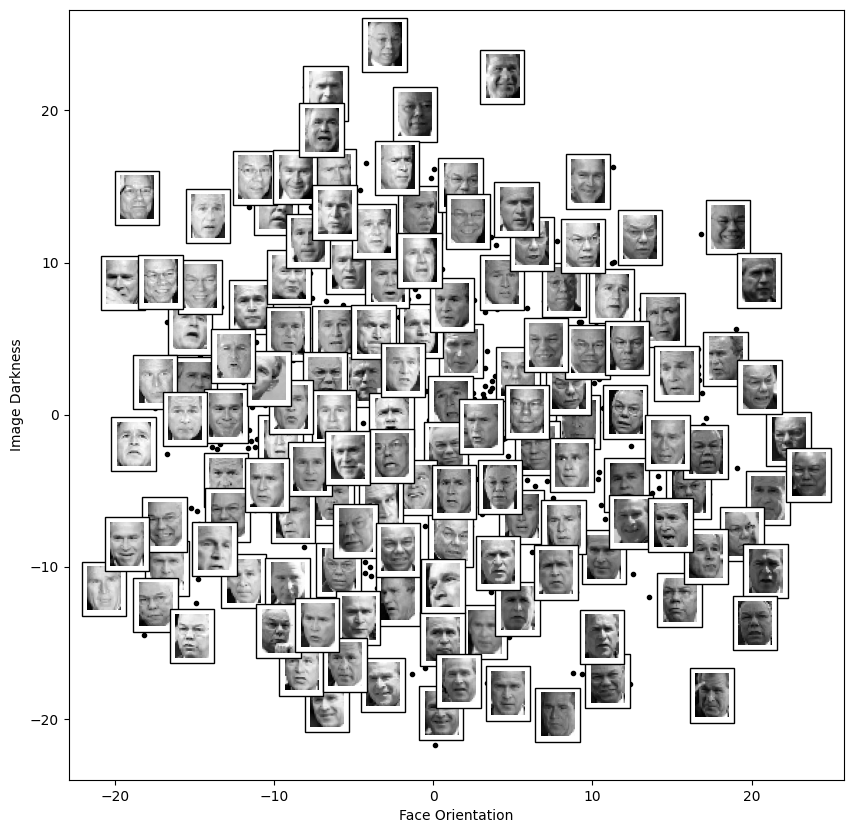

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

We get a very interesting result here. You can see that the Isomap was able to capture very interesting insights regarding the dataset.

If you observe along the x-axis, the images are positioned such that the orientation of the faces changes from left to right. Similarly, the darkness of the image increases in the positive direction of the y-axis.

This clearly indicates that Isomap was able to capture the underlying manifold very precisely in just 2 dimensions.

**You are motivated to play around with the number of neighbors and check if the following holds true across neighbourhoods!**



---


## Exercises!!

1. How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?

2. When is the ISOMAP algorithm superior to PCA?

3. Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

4. Suggest ways to deal with missing data in manifold learning.


---

## Conclusion:
In practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

1) In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.

2) In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.

3) The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.

4) In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.

5) In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.

6) In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

Therefore with all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.



1st Answer

In the Isomap algorithm (Isometric Mapping), the number of neighbors plays a critical role in defining the local neighborhood structure of the data. Isomap constructs a graph where each data point is connected to its nearest neighbors, and it relies on geodesic distances along this graph to preserve the data's manifold structure in a lower-dimensional space. Here’s how the number of neighbors affects the Isomap algorithm:1. When the number of neighbors is very large:Behavior:The Isomap algorithm begins to approximate global Euclidean distances rather than true geodesic distances.The neighborhood graph becomes more dense and might not properly capture the local manifold structure.Impact:This can lead to poor manifold learning because the algorithm no longer captures the "true" curved structure of the data.It behaves more like classical Multidimensional Scaling (MDS), which is designed to preserve Euclidean distances, not geodesic distances.2. When the number of neighbors is very low:Behavior:The neighborhood graph becomes sparse, and some points may not be connected to others.This can cause the algorithm to fail at constructing a continuous manifold or even produce disconnected graphs.Impact:The result is a loss of global structure since distant points are not properly connected via intermediate neighbors.The dimensionality reduction might not be meaningful because the graph may be broken into disconnected components, which leads to poor mapping in lower dimensions.Optimal choice of neighbors:There is a balance needed: too few neighbors, and the manifold might not be fully captured; too many neighbors, and the manifold structure is lost as the algorithm approaches global Euclidean distance preservation.The choice of the number of neighbors is often based on domain knowledge or experimentation with the data. Some cross-validation methods or visual inspection of the manifold can help guide this choice.In summary, the number of neighbors significantly impacts the performance of the Isomap algorithm:Large number of neighbors: Tends toward approximating Euclidean distances, potentially losing the non-linear structure of the manifold.Small number of neighbors: May fail to capture the global structure of the manifold, possibly creating disconnected clusters.

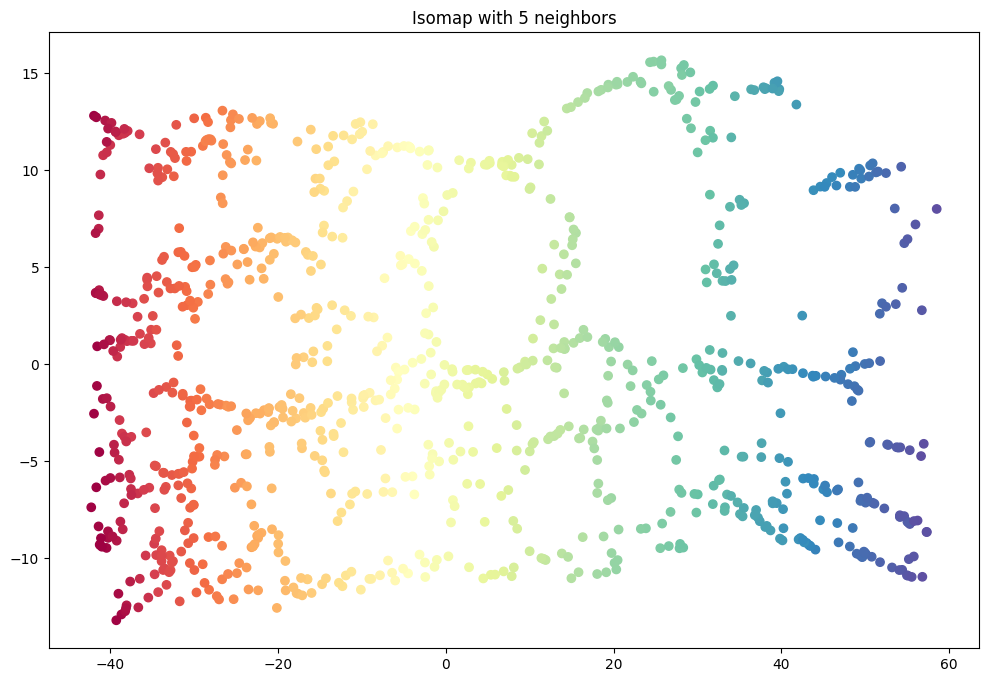

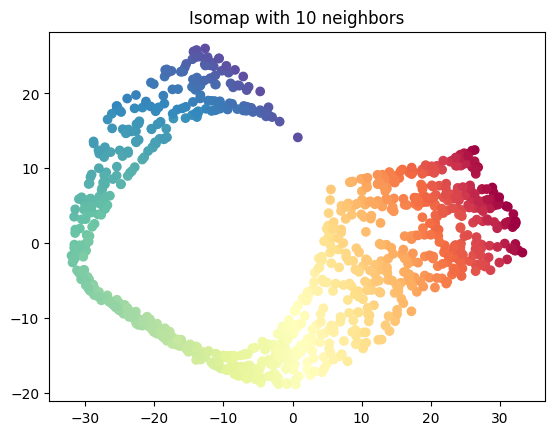

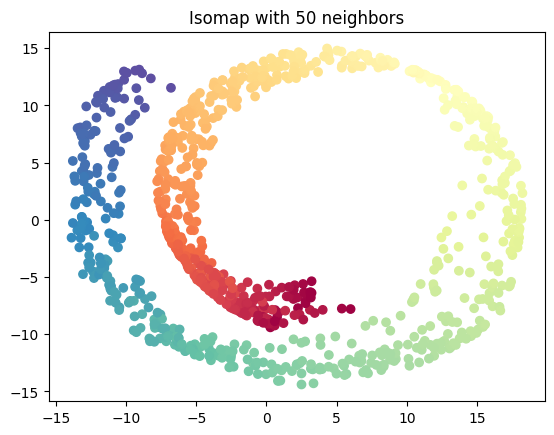

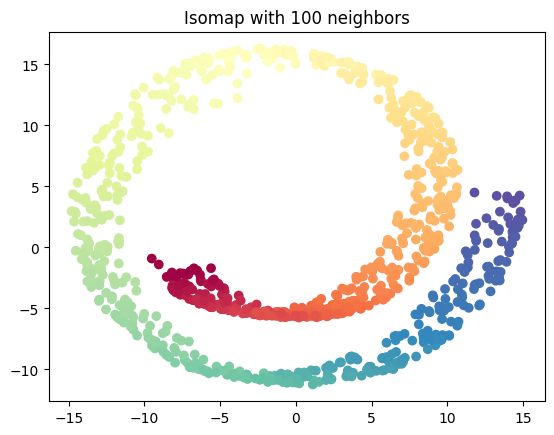

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import Isomap

# Step 1: Generate a synthetic dataset (Swiss Roll)
n_samples = 1000
X, color = make_swiss_roll(n_samples, noise=0.1)

# Step 2: Function to apply Isomap and visualize the results
def plot_isomap(X, color, n_neighbors, n_components=2):
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    X_transformed = isomap.fit_transform(X)

    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title(f'Isomap with {n_neighbors} neighbors')
    plt.show()

# Step 3: Apply Isomap with varying numbers of neighbors
neighbors_list = [5, 10, 50, 100]

plt.figure(figsize=(12, 8))
for n_neighbors in neighbors_list:
    plot_isomap(X, color, n_neighbors)

2nd Answer

The **Isomap** algorithm is superior to **PCA** in situations where the data lies on a **non-linear manifold** and preserving the **geodesic distances** (distances along the manifold) is crucial for dimensionality reduction. PCA, on the other hand, assumes the data lies on a **linear subspace** and attempts to preserve **global Euclidean distances**. Here are key scenarios where Isomap outperforms PCA:

### 1. **Non-linear Manifold Structure**
   - **Isomap**: Isomap excels when the data is sampled from a **non-linear manifold**, such as the **Swiss roll** or other curved surfaces. It preserves the underlying manifold's structure by maintaining the geodesic distances between points.
   - **PCA**: PCA fails to capture non-linear relationships because it relies on straight-line (Euclidean) distances and performs a linear transformation.

   **Example**: In the case of a Swiss roll dataset, PCA will flatten the data in a way that does not capture the true intrinsic structure, while Isomap will "unfold" the manifold, preserving the curved structure of the data in a lower-dimensional space.

### 2. **Preserving Global Structure**
   - **Isomap**: Isomap preserves both **local and global structure** by computing shortest paths along the manifold. This means distant points remain properly mapped in relation to their position on the manifold.
   - **PCA**: PCA only preserves **global linear distances**, which can distort relationships when the underlying structure is non-linear.

   **Example**: For complex data that curves or twists in high-dimensional space, Isomap will retain the global structure, while PCA might collapse parts of the data, misrepresenting the relationships between points.

### 3. **Geodesic Distance is Important**
   - **Isomap**: Isomap focuses on the **geodesic distance** (the distance measured along the manifold), making it better suited when the data points' true relationships are best described by this curved distance rather than straight-line Euclidean distance.
   - **PCA**: PCA preserves **Euclidean distance** between points, which may not be meaningful for data that follows a non-linear distribution.

### 4. **Unfolding of Complex Data**
   - **Isomap**: Isomap can **unfold complex, non-linear data structures** into a lower-dimensional space while maintaining meaningful relationships between points.
   - **PCA**: PCA would project the data in a linear fashion, distorting complex relationships or failing to reduce dimensionality in a meaningful way for non-linear data.

   **Example**: In biological or high-dimensional image data, where the relationship between features might be non-linear, Isomap can preserve the underlying structure more effectively than PCA.

### When PCA is better:
- **PCA** is typically superior when the data is inherently **linear** and the goal is to maximize variance in a low-dimensional linear subspace.
- PCA is also computationally simpler and faster than Isomap, making it more suitable for very large datasets with linear structure.

### Summary:
- **Use Isomap**: When data is **non-linear** and lies on a **manifold**, and when preserving **geodesic distances** and the global structure is important.
- **Use PCA**: When the data is **linear**, and the goal is to reduce dimensions while maximizing variance in a lower-dimensional **linear** space.

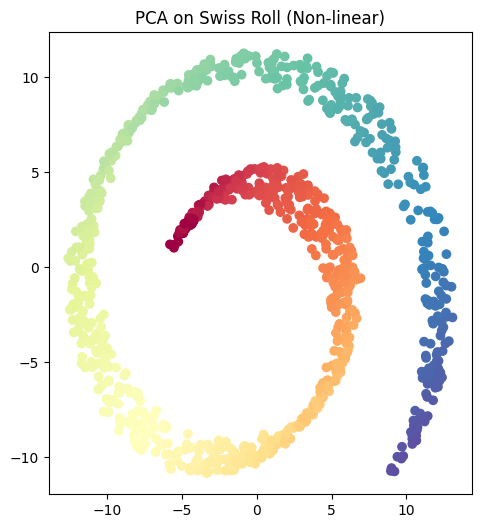

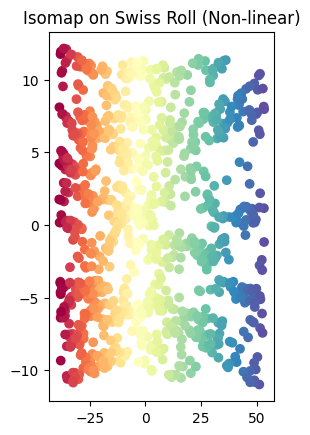

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


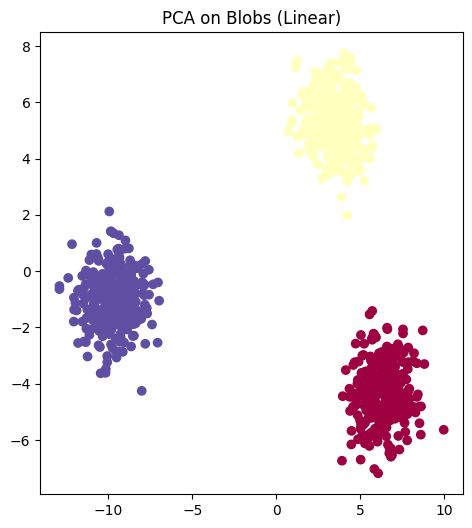

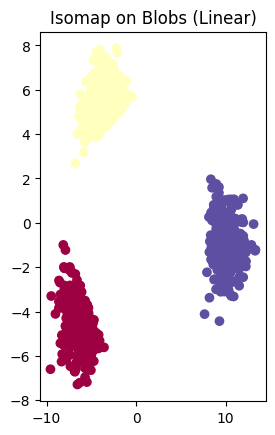

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.datasets import make_swiss_roll, make_blobs

# Function to plot results of dimensionality reduction
def plot_reduction(X_transformed, title, color):
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.show()

# Step 1: Generate a non-linear (Swiss Roll) and linear dataset
n_samples = 1000

# Non-linear dataset: Swiss roll
X_swiss, color_swiss = make_swiss_roll(n_samples, noise=0.1)

# Linear dataset: Blobs (linear separability)
X_blobs, color_blobs = make_blobs(n_samples=n_samples, centers=3, random_state=42)

# Step 2: Apply PCA and Isomap to both datasets
def apply_pca_isomap(X, color, dataset_name):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Apply Isomap
    isomap = Isomap(n_neighbors=10, n_components=2)
    X_isomap = isomap.fit_transform(X)

    # Plot the results for both PCA and Isomap
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plot_reduction(X_pca, f'PCA on {dataset_name}', color)

    plt.subplot(1, 2, 2)
    plot_reduction(X_isomap, f'Isomap on {dataset_name}', color)

# Step 3: Compare the performance of PCA and Isomap on the Swiss roll (non-linear)
apply_pca_isomap(X_swiss, color_swiss, "Swiss Roll (Non-linear)")

# Step 4: Compare the performance of PCA and Isomap on the Blob dataset (linear)
apply_pca_isomap(X_blobs, color_blobs, "Blobs (Linear)")

3rd Answer

There are several manifold learning methods aside from Isomap, each with unique approaches to dimensionality reduction. Here are a few prominent ones and their key differences:Locally Linear Embedding (LLE):Approach: LLE focuses on preserving local relationships by reconstructing each data point as a linear combination of its neighbors. It captures the intrinsic geometry of the manifold.Difference from Isomap: While Isomap uses geodesic distances between points, LLE emphasizes preserving local structures without relying on distance calculations across the entire manifold.t-Distributed Stochastic Neighbor Embedding (t-SNE):Approach: t-SNE converts high-dimensional Euclidean distances into conditional probabilities that represent similarities between points, emphasizing local structure. It is particularly effective for visualizing high-dimensional data in two or three dimensions.Difference from Isomap: t-SNE is more focused on visual representation and often used for clustering and exploring data rather than preserving global distances like Isomap.Laplacian Eigenmaps:Approach: This method constructs a graph based on the proximity of data points and uses spectral methods to project data into a lower-dimensional space while preserving local distances.Difference from Isomap: Laplacian Eigenmaps rely on a local neighborhood graph and minimize a cost function to preserve local relationships rather than estimating global geodesic distances as Isomap does.Kernel PCA:Approach: An extension of PCA, Kernel PCA uses kernel functions to project data into a higher-dimensional space where linear separation is possible, allowing it to capture non-linear structures.Difference from Isomap: Kernel PCA relies on transformations through kernels rather than distance-based methods, focusing more on linear projections in the transformed space.These methods can be selected based on the specific characteristics of the dataset and the goals of analysis, such as whether to emphasize local versus global structure, interpretability, or visualization capabilities【25†source】【26†source】【27†source】.

4th Answer

Dealing with missing data is a common challenge in manifold learning, as many algorithms require complete datasets to function effectively. Here are several strategies to handle missing data:Imputation:Mean/Median Imputation: Replace missing values with the mean or median of the available values for that feature. This is simple but can introduce bias, especially if the missingness is not random.K-Nearest Neighbors (KNN) Imputation: Use KNN to find the nearest neighbors of a point with missing data and replace the missing value with a weighted average of those neighbors' values. This method leverages the structure of the data to provide more informed imputations【34†source】【35†source】.Data Deletion:Listwise Deletion: Remove any data point (row) that has one or more missing values. This is straightforward but can lead to significant data loss and potential bias if the missing data is systematic .Pairwise Deletion: Use all available data for each analysis, ignoring missing values only for that specific analysis. This retains more data but may complicate the interpretation of results【34†source】.Model-Based Approaches:Expectation-Maximization (EM): This iterative method estimates missing values based on the observed data. It models the distribution of the data and estimates missing values while maximizing the likelihood of the observed data .Multiple Imputation: Generate several different plausible imputed datasets, analyze each one separately, and combine the results. This accounts for the uncertainty of the missing data【34†source】 .Using Algorithms Designed for Incomplete Data:Some manifold learning techniques, like t-SNE, can work with missing values to some extent. Modifying the algorithms or using versions that accommodate missing data can be beneficial【35†source】.Dimensionality Reduction before Imputation:Applying dimensionality reduction techniques like PCA or other manifold learning methods can help to understand the structure of the data and inform better imputation strategies by reducing the dimensionality before filling in missing values【34†source】.Sensitivity Analysis:After handling missing data, conducting sensitivity analyses to determine how different imputation methods affect results can provide insights into the robustness of the findings .ConclusionChoosing the right approach to handle missing data depends on the context of the data, the underlying mechanism of the missingness, and the specific manifold learning technique used. By employing these strategies, analysts can mitigate the negative effects of missing data on their results and improve the robustness of their manifold learning outcomes. For further details, you may want to explore resources discussing these strategies in more depth【34†source】【35†source】 .


---


### Some interesting references:

1) https://axon.cs.byu.edu/Dan/678/miscellaneous/Manifold.example.pdf

2) http://vision.cse.psu.edu/seminars/talks/PRML/David_NDR_lecture.pdf


---

